In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

%load_ext tensorboard

In [2]:
import tensorflow.keras as keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

from keras.layers.merge import concatenate

from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

samples= 5
tipo = 3    # np.random.randint(4)
index_image = np.random.randint(100000)  


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print(example_dict['labels'].shape)
print(example_dict['images'].shape)

L=example_dict['labels'].shape[0] #numero total de imagenes

input_images=example_dict['images'][:40000, :, :, tipo]
input_images=np.expand_dims(input_images, axis=-1)

#padded
input_images=np.pad(input_images, ((0,0),(2,1), (2,1), (0, 0)), 'constant')


print(input_images.shape)

(100000,)
(100000, 21, 21, 4)
(40000, 24, 24, 1)


In [5]:
#normalization
def normalize(processed):
    ####### calculate global mean and standard deviation
    mean, std = processed.mean(), processed.std()
    #print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    ####### global standardization of pixels
    processed = (processed - mean) / std
    ####### clip pixel values to [-1,1]
    processed = np.clip(processed, -1.0, 1.0)
    ####### shift from [-1,1] to [0,1] with 0.5 mean
    processed = (processed + 1.0) / 2.0
    #print('after normalization')
    #print('Valor máximo :', processed.max())
    #print('Valor mínimo :', processed.min())
    return processed

In [6]:
#preprocess 3D to 2D

def preprocessar_2d(ximg):

    print(ximg.shape)
    x= np.squeeze(ximg, axis=2)  
    print('---->', x.shape)

    
    return x

shape de mapas de oclusion: (40000, 21, 21, 1)
(21, 21, 1)
----> (21, 21)
Nº labels:  40000


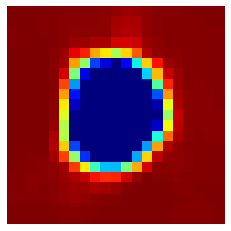

In [7]:
%matplotlib inline

imagem=30000      #Choose image to visualize


archivo_occluded = open('./dataset/OCmaps_F.pkl',"rb")
OCmaps= pickle.load(archivo_occluded)



OCimg=OCmaps["image"]

print("shape de mapas de oclusion:", OCimg.shape)
input_shape=OCimg[imagem].shape
OCimg=preprocessar_2d(OCimg[imagem])


labelOcc=OCmaps["label"]
labelOcc=labelOcc[:OCmaps["image"].shape[0]]

n_labels=  labelOcc.shape[0]

#print("labels shape: ", labelOcc.shape)
print("Nº labels: ", n_labels)


plt.imshow(OCimg, cmap='jet')                #[2:19, 2:19])
plt.axis("off")


plt.show()




(40000, 24, 24, 1)
input shape:  (24, 24, 1)
(24, 24, 1)
----> (24, 24)


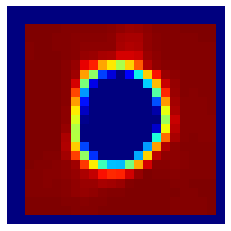

In [8]:
#padding images

occ_img_padded=np.pad(OCmaps["image"], ((0,0),(2,1), (2,1), (0, 0)), 'constant')
print(occ_img_padded.shape)
input_shape=occ_img_padded[imagem].shape
print('input shape: ', input_shape)

plt.imshow(preprocessar_2d(occ_img_padded[imagem]), cmap='jet')                #[2:19, 2:19])
plt.axis("off")


plt.show()

In [9]:
############ modelo Autoencoder en Keras #################


def autoencoder_test():

    model = Sequential()
    #conv
    model.add(Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1),
                     input_shape=input_shape))
    #conv
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))              
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(36, activation='softmax'))

#

    model.add(Reshape((6,6,1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))    
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))  
    #upsamp
    model.add(UpSampling2D(size=(2, 2))) 
    
    #conv
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1)))
 
    #upsamp
    model.add(UpSampling2D(size=(2, 2))) 
    
    #conv
    model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', strides=(1, 1)))
    
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')

    return model

In [10]:
def encoder(classifier, dim, mode=True):
    
    weights = classifier.layers[0].get_weights()
    print(weights[0].shape)
    print(weights[1].shape)

    
    
    model = Sequential()
    #conv
    model.add(Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1),
                     input_shape=input_shape, trainable=False))
    #conv
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1), trainable=mode))
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1), trainable=mode))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1), trainable=mode))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1), trainable=mode))              
    #max-pool
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(dim, activation='softmax'))
    
    if mode==False:
        model.layers[0].set_weights(classifier.layers[0].get_weights())
        model.layers[1].set_weights(classifier.layers[1].get_weights())
        model.layers[3].set_weights(classifier.layers[3].get_weights())
        model.layers[4].set_weights(classifier.layers[4].get_weights())
        model.layers[5].set_weights(classifier.layers[5].get_weights())
        
        
    
    return model

In [11]:
def decoder(model):

    

    model.add(Reshape((6,6,1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))    
    #conv
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', strides=(1, 1)))  
    #upsamp
    model.add(UpSampling2D(size=(2, 2))) 
    
    #conv
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1, 1)))
    #conv
    model.add(Conv2D(32, kernel_size=(4, 4), padding='same', strides=(1, 1)))
 
    #upsamp
    model.add(UpSampling2D(size=(2, 2))) 
    
    #conv
    model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', strides=(1, 1)))
    
    

    return model

In [12]:
def autoencoder(model, verbose=0):
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    if verbose==1:
        for i,layer in enumerate(model.layers):
            print(i,layer.name)
    
    return model


In [13]:
encoder=encoder(load_model('supernova_class.model'), 36, False) #aqui modelo 
model=autoencoder(decoder(encoder), verbose=1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(4, 4, 1, 32)
(32,)

0 conv2d_1
1 conv2d_2
2 max_pooling2d_1
3 conv2d_3
4 conv2d_4
5 conv2d_5
6 max_pooling2d_2
7 flatten_1
8 dense_1
9 reshape_1
10 conv2d_6
11 conv2d_7
12 conv2d_8
13 up_sampling2d_1
14 conv2d_9
15 conv2d_10
16 up_sampling2d_2
17 conv2d_11


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [15]:
#entrenar
epocas=2
batch=10
x_train=occ_img_padded

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#print('input shape: ', x_train.shape)

model.fit(input_images, x_train,
                epochs=epocas,
                batch_size=batch,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='./tmp/autoencoder')])




Epoch 1/2
40000/40000 [==============================] - 79s 2ms/step - loss: 0.3769
Epoch 2/2
40000/40000 [==============================] - 75s 2ms/step - loss: 0.3594


In [16]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [17]:
%tensorboard --logdir ./tmp/autoencoder

Reusing TensorBoard on port 6006 (pid 7858), started 5:24:16 ago. (Use '!kill 7858' to kill it.)

In [29]:
decoded_imgs = model.predict(input_images, verbose=1)

40000/40000 [==============================] - 25s 632us/step


In [30]:
print(mse(x_train[imagem], decoded_imgs[imagem]))

0.006584045325639199


(24, 24, 1)
----> (24, 24)


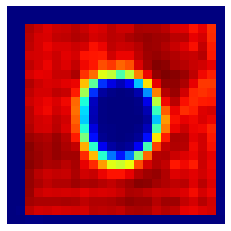

In [88]:
test=8001

plt.imshow(preprocessar_2d(decoded_imgs[test]), cmap='jet')
plt.axis("off")


plt.show()

(24, 24, 1)
----> (24, 24)


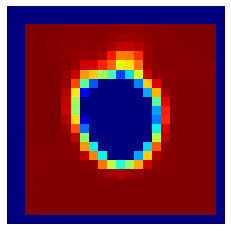

In [89]:
plt.imshow(preprocessar_2d(occ_img_padded[test]), cmap='jet')
plt.axis("off")


plt.show()

In [90]:
print(mse(x_train[test], decoded_imgs[test]))

0.003462150119107915


(24, 24, 1)
----> (24, 24)


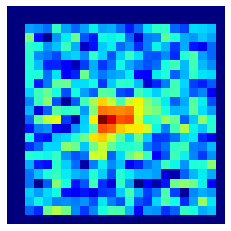

In [91]:
plt.imshow(preprocessar_2d(input_images[test]), cmap='jet')
plt.axis("off")


plt.show()

In [92]:
encoder = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)

In [64]:
encoded_imgs = encoder.predict(input_images, verbose=1)

40000/40000 [==============================] - 17s 420us/step


In [93]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
__________

In [94]:
print(encoded_imgs.shape)

(40000, 36)


In [95]:
print(encoded_imgs[test])

[3.1549579e-08 2.8421185e-08 3.3283801e-08 2.2588102e-08 2.0272651e-08
 1.4618731e-08 1.2903372e-08 9.9480081e-01 7.8380022e-09 2.4854589e-08
 2.4360615e-08 1.8501321e-08 5.1976033e-03 2.0585576e-08 2.5829789e-09
 6.8692052e-10 1.8914941e-08 4.5521517e-08 5.1523340e-08 3.6250576e-08
 1.2326817e-08 1.4300088e-07 6.9200119e-08 1.3184705e-07 7.8189984e-08
 2.2336101e-08 6.4345023e-09 1.8152576e-08 3.0245931e-07 2.1847472e-07
 3.6259014e-08 1.2445911e-08 3.4006753e-08 3.5574793e-08 9.1583161e-08
 3.2316734e-08]
